<h1><center>Feedforward Neural Network</center></h1>

<h3>This is the implementation of the Feedforward Neural Network and its application for a non-linear identification (heat exchanger process) </h3>

<p>Import of the libraries</p>

In [1]:
# library to create the Multilayer Perceptron
from sklearn.neural_network import MLPRegressor

# library to calculate the mean square error
from sklearn.metrics import mean_squared_error

# library to use the numpy array
import numpy as np

# library to plot 
import matplotlib.pyplot as plt

# library to understand the progress of a cycle
from tqdm import tqdm

# give the dimensions of the plot
%pylab inline
pylab.rcParams['figure.figsize'] = (20, 10)

Populating the interactive namespace from numpy and matplotlib


<p>Read data from files
<ul>
<li>$y(t)$ is the outlet liquid temperature</li>
<li>$u(t)$ is the liquid flow rate</li>
</ul>
</p>

In [2]:
# open file and read data
data = open('../exchanger/exchanger.dat')
lst = []
for line in data:
    lst += [line.split()]
time = [float(x[0]) for x in lst]
u = [float(x[1]) for x in lst]
y = [float(x[2]) for x in lst]

<p>Divide the dataset in identification and validation set</p>

In [3]:
# identification length
ID_LENGHT = 3000

# validation length
VAL_LENGHT = 1000

# identification set and means
time_id = time[:ID_LENGHT]
u_id = u[:ID_LENGHT]
y_id = y[:ID_LENGHT]
avg_y_id = np.mean(y_id)
avg_u_id = np.mean(u_id)

# validation set and means
time_val = time[ID_LENGHT:]
u_val = u[ID_LENGHT:]
y_val = y[ID_LENGHT:]
avg_y_val = np.mean(y_val)
avg_u_val = np.mean(u_val)

<p>Definition of:
<ul>
<li>Autoregressive part: AR_deg;</li>
<li>Exogenus part: X_deg;</li>
<li>Units in each layer: unit_per_hidden</li>
</ul>
</p>

In [4]:
AR_deg = 4
X_deg = 10
unit_per_hidden = tuple([14,7])

<p>The model used is: <br>
<center>$\hat{y} (t+1|t) = f(y(t), y(t-1) ... y(t-3); u(t), u(t-1), ... u(t-9))$</center>
</p>

<h5>Creation of the Multilayer Perceptron using 14 units in the $1^{st}$ hidden layer and 7 in the $2^{nd}$

In [5]:
mlp = MLPRegressor(hidden_layer_sizes=unit_per_hidden, activation="logistic", solver="lbfgs", verbose=False,\
                   random_state=13)

<p>Creation of $\Phi$ for the input of the NN</p>

In [6]:
Y = np.array(y_id)
reg_u = np.full(X_deg,avg_u_id)
reg_y = np.full(AR_deg,avg_y_id)
PHI = []
for i in range(ID_LENGHT):
    if i!=0:
        reg_y = np.append(reg_y, Y[i])[1:]
        reg_u = np.append(reg_u, u_id[i])[1:]
    regressors = np.append(reg_u, reg_y)
    PHI.append(regressors)
PHI = np.array(PHI)

<p>Train of the NN</p>

In [7]:
model = mlp.fit(PHI,Y)

<h5>Prediction: $\hat{y}$</h5>

In [8]:
y_hat = model.predict(PHI)

Plot of the process and the prediction on the identification set

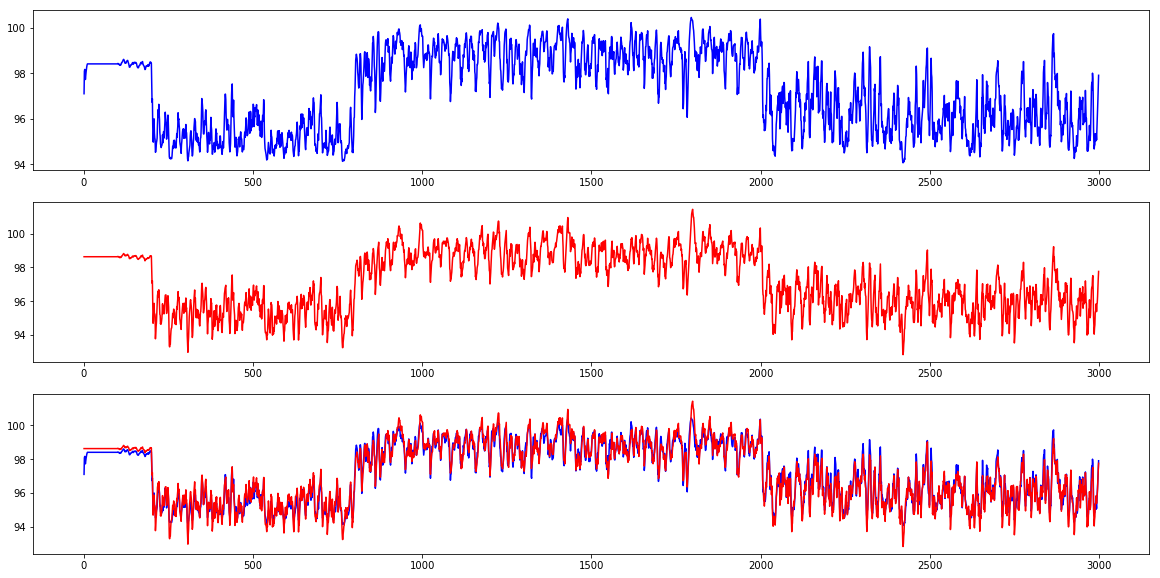

MSE on identification:  0.0917548317481


In [9]:
plt.subplot(311)
plt.plot(y_hat, color='blue')
plt.subplot(312)
plt.plot(y_id, color='red')
plt.subplot(313)
plt.plot(y_hat, color='blue')
plt.plot(y_id, color='red')
plt.show()

MSE_id = mean_squared_error(y_id,y_hat)
print("MSE on identification: ", MSE_id)

<h5>Test on the validation set</h5>
<p>Creation of $\Phi_{val}$ on the data of the validation set </p>

In [10]:
Y_val = np.array(y_val)
reg_u = np.full(X_deg,avg_u_val)
reg_y = np.full(AR_deg,avg_y_val)
PHI_val = []
for i in tqdm(range(VAL_LENGHT)):  
    if i!=0:
        reg_y = np.append(reg_y, Y_val[i])[1:]
        reg_u = np.append(reg_u, u_val[i])[1:]
    regressors = np.append(reg_u, reg_y)
    PHI_val.append(regressors)
PHI_val = np.array(PHI_val)

100%|██████████| 1000/1000 [00:00<00:00, 56264.64it/s]


<h5>Prediction: $\hat{y}_{val}$</h5>

In [11]:
y_hat_val = model.predict(PHI_val)

Plot of the process and the prediction on the validation set

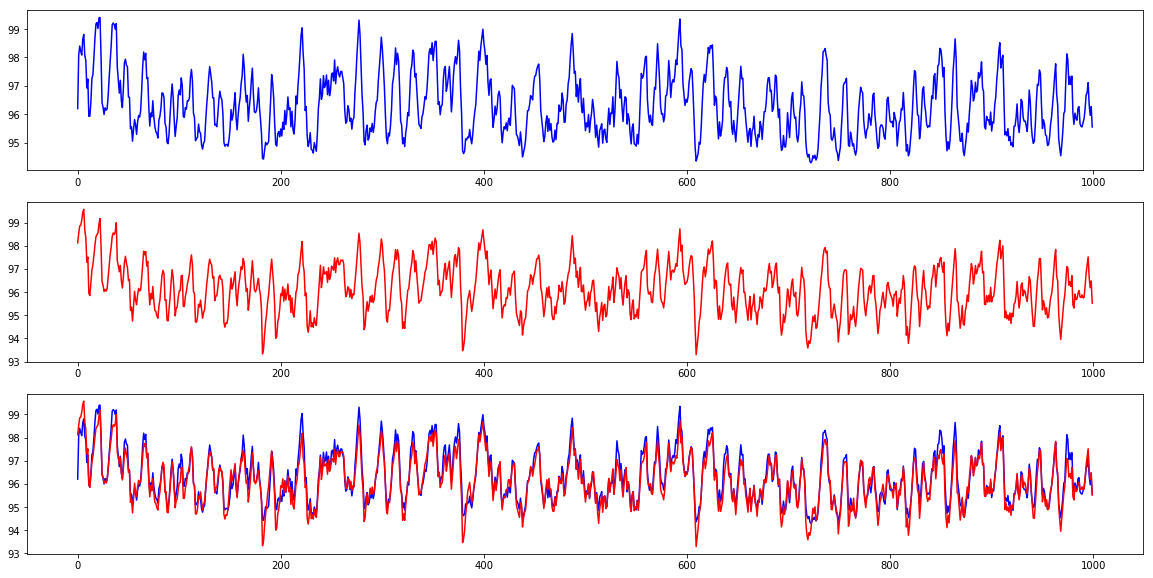

MSE on validation:  0.119967048437


In [12]:
plt.subplot(311)
plt.plot(y_hat_val, color='blue')
plt.subplot(312)
plt.plot(y_val, color='red')
plt.subplot(313)
plt.plot(y_hat_val, color='blue')
plt.plot(y_val, color='red')
plt.show()

MSE_val = mean_squared_error(y_val,y_hat_val)
print("MSE on validation: ", MSE_val)

<h3>Model Validation</h3>
<h6>Correlation tests</h6>

/Users/salvatoredamicis/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


(-1, 1)

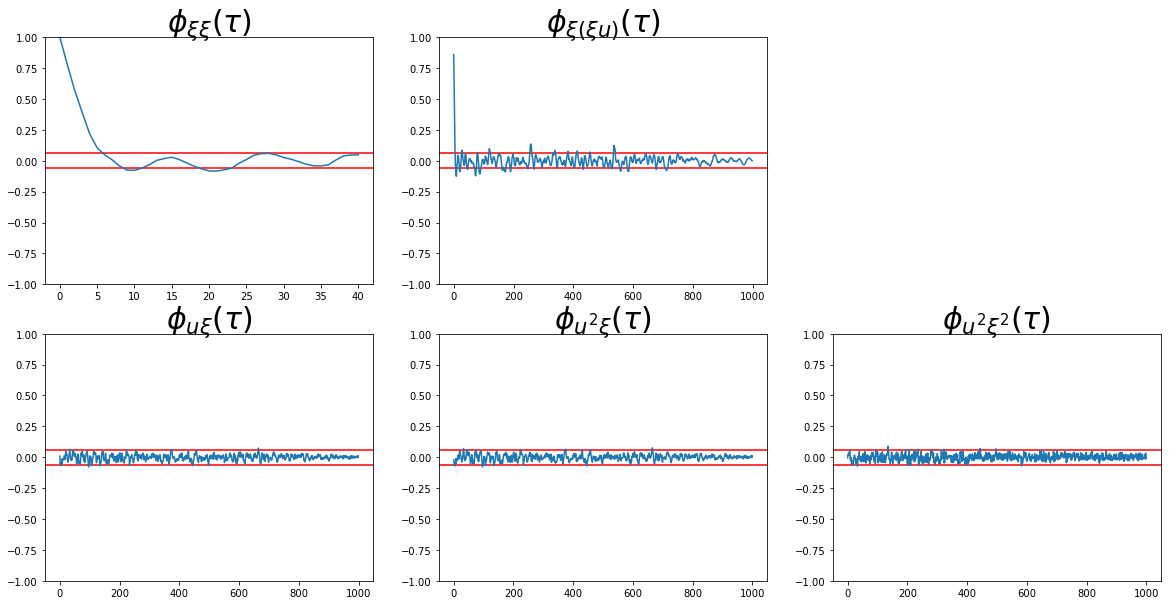

In [13]:
#import of the library
from statsmodels.tsa.stattools import acf , ccf
epsilon = np.array(y_val - y_hat_val)
u_val = np.array(u_val)

#Autocorrelation epsilon
corr_ee = acf(epsilon)

#Cross-correlation u-epsilon
corr_ue = ccf(u_val, epsilon,unbiased=False)

#Cross-correlation epsilon ( epsilon*u)
corr_e_eu = ccf(epsilon,np.multiply(epsilon[1:],u_val[1:]),unbiased=False)

#Cross-correlation delta(u^2)-epsilon
corr_du2_e = ccf(np.power(u_val,2) - np.mean(np.power(u_val,2)),epsilon, unbiased=False)

#Cross-correlation delta(u^2)-epsilon
corr_du2_e2 = ccf(np.power(u_val,2) - np.mean(np.power(u_val,2)),np.power(epsilon,2), unbiased=False)

#confidence interval   -95%
conf_interval_sup = 1.96 / np.sqrt(VAL_LENGHT)
conf_interval_inf = -1.96 / np.sqrt(VAL_LENGHT)
plt.subplot(231)
plt.title(r'$\phi_{\xi\xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_ee)
plt.ylim((-1,1))
plt.subplot(232)
plt.title(r'$\phi_{\xi(\xi u)}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_e_eu)
plt.ylim((-1,1))
plt.subplot(234)
plt.title(r'$\phi_{u \xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_ue)
plt.ylim((-1,1))
plt.subplot(235)
plt.title(r'$\phi_{u^2\xi}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_du2_e)
plt.ylim((-1,1))
plt.subplot(236)
plt.title(r'$\phi_{u^2\xi^2}(\tau)$', fontsize=30)
plt.axhline(y=conf_interval_sup, color = "red")
plt.axhline(y=conf_interval_inf, color = "red")
plt.plot(corr_du2_e2)
plt.ylim((-1,1))


<h3>Simulation</h3>

In [14]:
# start from initial phi (reg_y + reg_u), then build step by step adding new elements
reg_y = np.full(AR_deg,avg_y_val)
reg_u = np.full(X_deg,avg_u_val)
reg = np.append(reg_u,reg_y)

<h5>Simulate the process</h5>

In [15]:
y_hat_sim  = []
for i in range(VAL_LENGHT):
    y_i = model.predict([reg]) #simulated
    y_hat_sim.append(y_i)
    reg_y = np.append(reg_y, y_hat_sim[i])[1:]
    reg_u = np.append(reg_u, u_val[i])[1:]  #append at beggining, then remove the first one([:1])
    reg = np.append(reg_u,reg_y)

Plot of the process and the simulation on the validation set

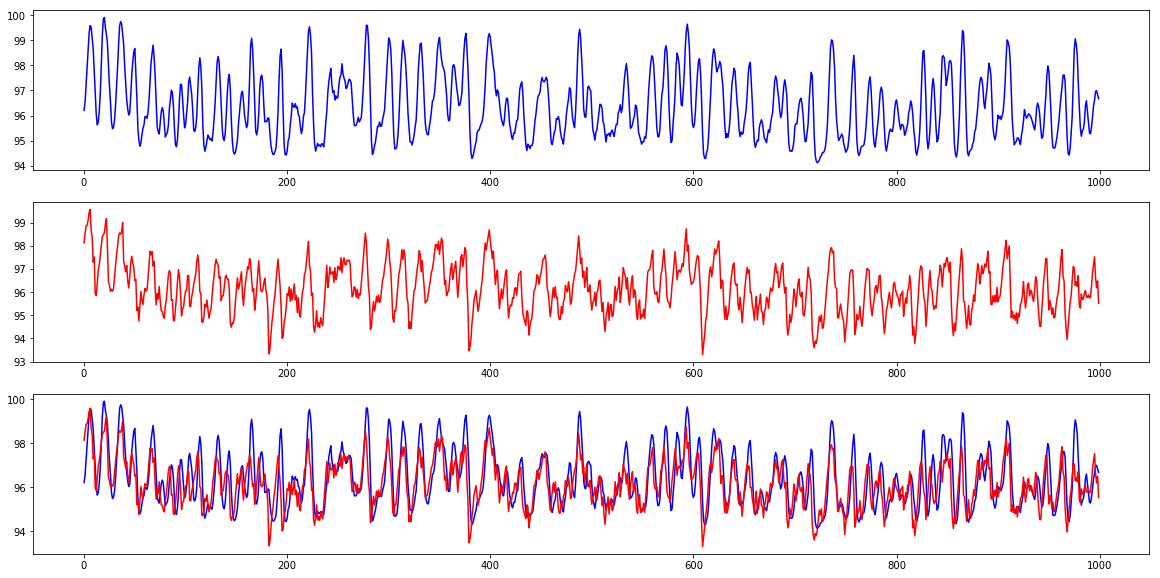

MSE on simulation:  0.935325908845


In [16]:
plt.subplot(311)
plt.plot(y_hat_sim, color='blue')
plt.subplot(312)
plt.plot(y_val, color='red')
plt.subplot(313)
plt.plot(y_hat_sim, color='blue')
plt.plot(y_val, color='red')
plt.show()

MSE_sim = mean_squared_error(y_val,y_hat_sim)
print("MSE on simulation: ", MSE_sim)

<p>From this code, a script has been created to test different model assumption and complexities</p>